- refactor the files... e.g. simulation code split between standard DGPs and code that makes data, rename hte_caret, move iptw/ipcw to different places
- implement value and c-index functions. (remember: ipcw is needed b/c KM by itself doesn't adjust for *informative* censoring)
- test everything together
- run sims and look at results

In [293]:
library(plyr)
library(magrittr)
library(distr)
library(distrEx)
library(gbm)
library(Matching)
library(caret)
library(tidyverse)
source("R/simulation_scenarios.R")
source("R/hte_caret.R")
source("R/eval_hte_cv.R")
source("R/hte_cv.R")

In [268]:
DGP = list()
n = 5

X1 = Norm(mean=1)
X2 = Norm(mean=1)
DGP$X = list(X1, X2)

DGP$f_W_x = function(x, w) {
    logit_p = x[1] + x[2]
    p = exp(logit_p) / (1 + exp(logit_p))
    Binom(prob=p)
}

DGP$f_Y_xw = function(x, w) {
    if(w) {
        Weibull(scale= exp(x[2]), 
                shape=1.2)
    } else {
        Weibull(scale= exp(x[1]), 
                shape=1.2)
    }
}

DGP$f_C_xw = function(x, w) {
    Weibull(scale=4, 
            shape=1.4)
}

In [291]:
datas = setup_data(DGP, 1000, 5000, 3)

In [294]:
models = list(
    rf_spec = list(method = two_model_surv_rf,
                   tune_grid = expand.grid(num.trees = 500,
                                           mtry = 1,
                                           min.node.size = 3)),
    gbm_spec = list(method = gbm_ph,
                    tune_grid = expand.grid(n.trees = seq(1,1001,20), 
                                            interaction.depth=3, 
                                            shrinkage = 0.05, 
                                            n.minobsinnode=3)))
estimates = datas %$% get_estimates(data, models, cv_index, test_index)

Growing trees.. Progress: 94%. Estimated remaining time: 2 seconds.


In [283]:
metrics =  estimates %$% get_metrics(cv_estimates, test_estimates, datas$aux_data) 

Warning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vectorWarning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vectorWarning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vectorWarning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vector

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


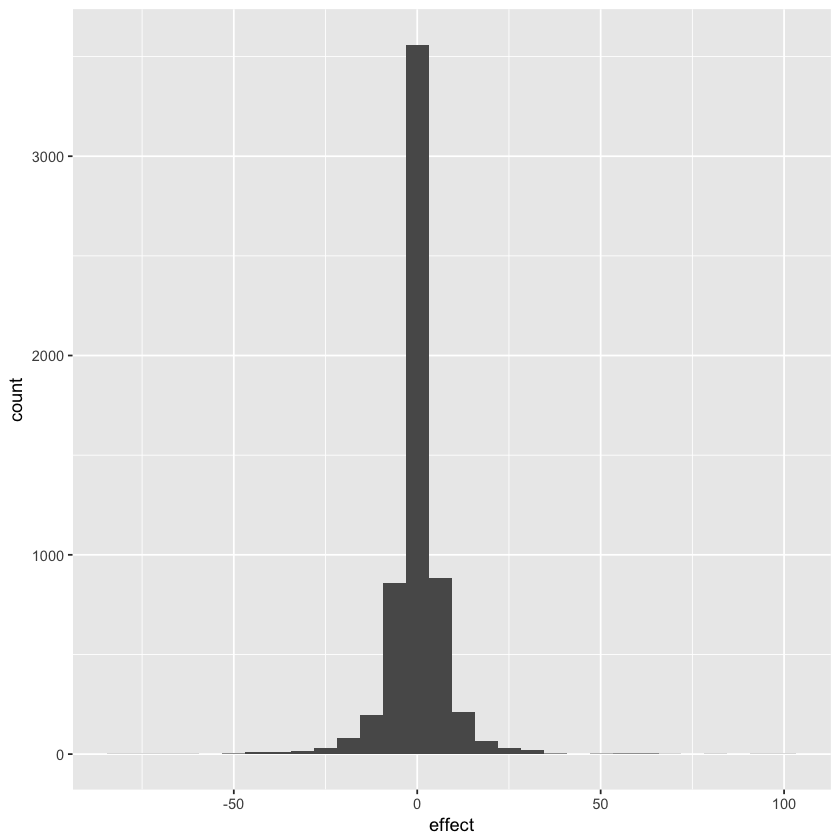

In [273]:
datas$aux_data %$% qplot(effect)

In [284]:
estimates$test_estimates %>% 
    filter(model == "two_model_surv_rf~1000~1~3") %>%
#     filter(model == "gbm_ph~701~3~0.05~3") %>%
    inner_join(datas$aux_data, by="subject") %$%
# qplot(effect, est_effect)
cor(effect, est_effect)

[1] 0.09049454

Warning message:
: Too few values at 3 locations: 52, 104, 156

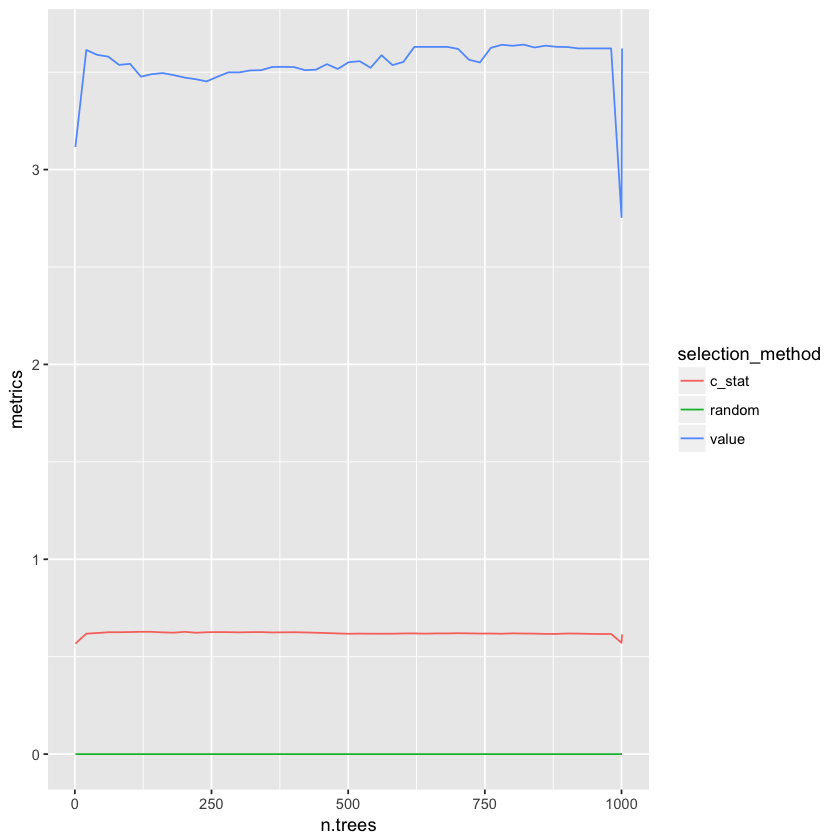

In [285]:
metrics$cv_metrics %>%
    separate(model, c("model", names(models$gbm_spec$tune_grid)), sep="~") %>%
    mutate(n.trees = as.numeric(n.trees)) %>%
# data.frame %>% str
ggplot(aes(x=n.trees, y=metrics, color=selection_method)) + 
    geom_line()

In [260]:
metrics$cv_metrics  %>% filter(selection_method=="c_stat")

# A tibble: 52 x 3
   model                selection_method metrics
   <chr>                <chr>              <dbl>
 1 gbm_ph~1~3~0.05~3    c_stat             0.594
 2 gbm_ph~1001~3~0.05~3 c_stat             0.659
 3 gbm_ph~101~3~0.05~3  c_stat             0.666
 4 gbm_ph~121~3~0.05~3  c_stat             0.667
 5 gbm_ph~141~3~0.05~3  c_stat             0.669
 6 gbm_ph~161~3~0.05~3  c_stat             0.669
 7 gbm_ph~181~3~0.05~3  c_stat             0.667
 8 gbm_ph~201~3~0.05~3  c_stat             0.668
 9 gbm_ph~21~3~0.05~3   c_stat             0.649
10 gbm_ph~221~3~0.05~3  c_stat             0.666
# ... with 42 more rows

Warning message:
: Too few values at 1 locations: 52

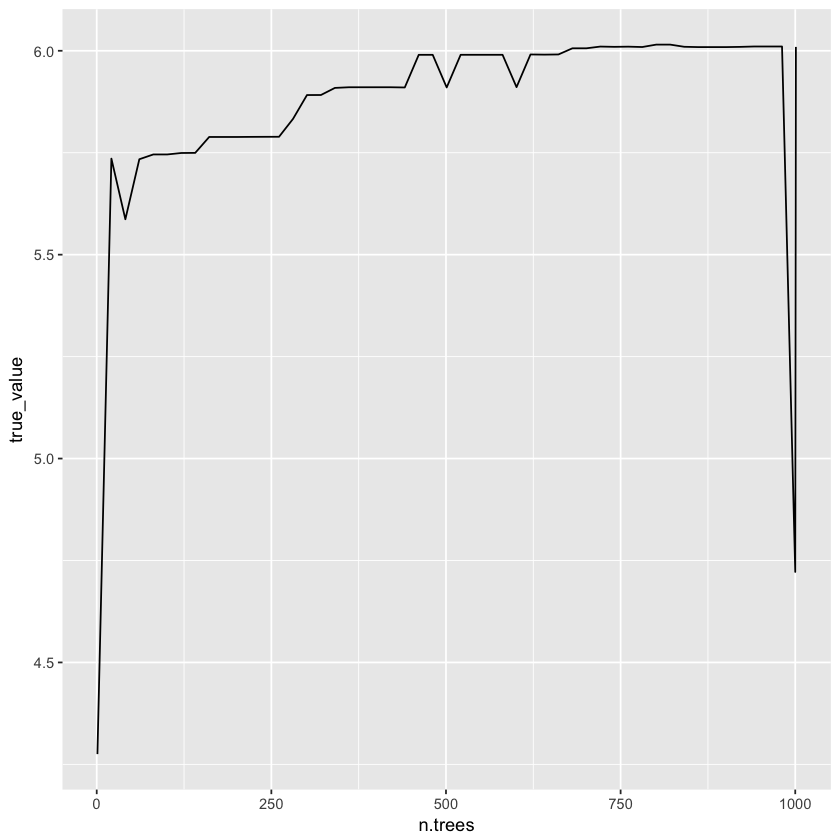

In [286]:
metrics$test_metrics %>%
    separate(model, c("model", names(models$gbm_spec$tune_grid)), sep="~") %>%
    mutate(n.trees = as.numeric(n.trees)) %>%
# data.frame %>% str
ggplot(aes(x=n.trees, y=true_value)) + 
    geom_line()

In [289]:
?bind_rows

bind {dplyr},R Documentation
...,"Data frames to combine. Each argument can either be a data frame, a list that could be a data frame, or a list of data frames. When row-binding, columns are matched by name, and any missing columns with be filled with NA. When column-binding, rows are matched by position, so all data frames must have the same number of rows. To match by value, not position, see join."
.id,"Data frame identifier. When .id is supplied, a new column of identifiers is created to link each row to its original data frame. The labels are taken from the named arguments to bind_rows(). When a list of data frames is supplied, the labels are taken from the names of the list. If no names are found a numeric sequence is used instead."


In [287]:
metrics$test_metrics %>% data.frame

,model,true_value
1,gbm_ph~1~3~0.05~3,4.275181
2,gbm_ph~1001~3~0.05~3,6.009491
3,gbm_ph~101~3~0.05~3,5.745737
4,gbm_ph~121~3~0.05~3,5.749314
5,gbm_ph~141~3~0.05~3,5.749605
6,gbm_ph~161~3~0.05~3,5.788605
7,gbm_ph~181~3~0.05~3,5.788604
8,gbm_ph~201~3~0.05~3,5.788604
9,gbm_ph~21~3~0.05~3,5.73548
10,gbm_ph~221~3~0.05~3,5.788866


In [288]:
metrics$true_selection_metrics %>% data.frame

,model,selection_method,true_value
1,gbm_ph~121~3~0.05~3,c_stat,5.749314
2,gbm_ph~401~3~0.05~3,random,5.910546
3,gbm_ph~821~3~0.05~3,value,6.015117
4,gbm_ph~801~3~0.05~3,oracle_selector_true_value,6.015117
5,truth,oracle,2.06753
6,harm,demon,6.487192
